In [1]:
#!/usr/bin/python
#dbr 8/9/24
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.cm as cm
import seaborn as sns

sns.set_style("ticks")

#for mem
import statsmodels.api as sm
import statsmodels.formula.api as smf


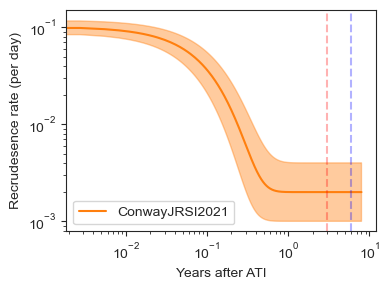

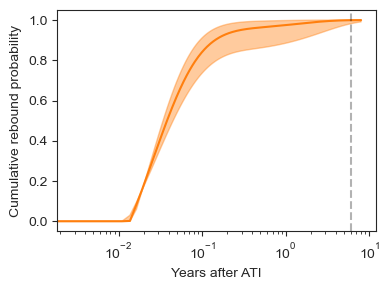

In [17]:
#simulate for 6? years

tF = 365*8
tsim = np.arange(0,tF)

#full model, Conway et al parameters, JRSI 2021

r0    = 0.088           #per day
r0CI  = (0.073,0.106)
rf    = 0.002 #per day
rfCI  = (0.001, 0.004)
k     = 0.029           #per day
kCI   = (0.022,0.040)
tau   = 4.98            #days
tauCI = (4.58,5.41)

#function for conway
def calc_pVR(tsim,r0,rf,k,tau):
    
    ek = np.exp(-k*(tsim-tau))
    rt = rf + (r0-rf)*ek #rate over time  
    S = r0/k*(ek-1)-rf/k*(ek-1+k*(tsim-tau)) #integrated this out  
    P = 1 - np.exp(S)
    
    return np.heaviside(tsim-tau,0)*P,rt

pVR,rt=calc_pVR(tsim,r0,rf,k,tau)
pVRlo,rtlo=calc_pVR(tsim,r0CI[0],rfCI[0],kCI[1],tauCI[0])
pVRhi,rthi=calc_pVR(tsim,r0CI[1],rfCI[1],kCI[0],tauCI[1])

#just show recrudesence rate over time
plt.figure(figsize=(4,3))
plt.plot(tsim/365,rt,label='ConwayJRSI2021',color='tab:orange')
plt.fill_between(tsim/365,rtlo,rthi,color='tab:orange',alpha=0.4)
plt.loglog()
plt.axvline(3,ls='--',color='red',alpha=0.3)
plt.axvline(6,ls='--',color='blue',alpha=0.3)
#plt.semilogy(tsim/365,0.1*np.exp(-tsim*1.5e-3),color='navy')
plt.legend()
plt.xlabel('Years after ATI')
plt.ylabel('Recrudesence rate (per day)')
plt.tight_layout()
plt.savefig('figures/recrudrateConway.pdf',dpi=600)

#rebound probability
plt.figure(figsize=(4,3))
plt.plot(tsim/365,pVR,label='ConwayJRSI2021',color='tab:orange')
plt.fill_between(tsim/365,pVRlo,pVRhi,color='tab:orange',alpha=0.4)
plt.semilogx()
#plt.axvline(3,ls='--',color='red',alpha=0.3)
plt.axvline(6,ls='--',color='k',alpha=0.3)
plt.xlabel('Years after ATI')
plt.ylabel('Cumulative rebound probability')
plt.tight_layout()
plt.savefig('figures/cumulativeConway.pdf',dpi=600)




In [3]:
#% chance of not rebounding by 6 years given normal

print((1-calc_pVR(6*365,r0,rf,k,tau)[0])*100, '[', 
      (1-calc_pVR(6*365,r0CI[1],rfCI[1],kCI[0],tauCI[1])[0])*100, ',' ,
        (1-calc_pVR(6*365,r0CI[0],rfCI[0],kCI[1],tauCI[0])[0])*100, ']')

0.06519405107513476 [ 0.0001553929558251177 , 1.8584637135746318 ]


In [4]:
#% chance of not rebounding by 3 years given normal

print((1-calc_pVR(3*365,r0,rf,k,tau)[0])*100, '[', 
      (1-calc_pVR(3*365,r0CI[1],rfCI[1],kCI[0],tauCI[1])[0])*100, ',' ,
        (1-calc_pVR(3*365,r0CI[0],rfCI[0],kCI[1],tauCI[0])[0])*100, ']')

0.5825227401668909 [ 0.012406268000231258 , 5.555287550332199 ]


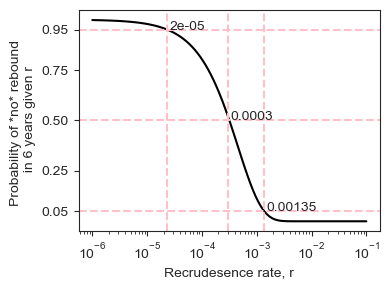

In [5]:
#now using more classical model
#get the probability of rebound at 6 years
#nd then say the chance you haven't rebounded yet given those parameters

r=np.logspace(-6,-1,100)
    
P   = (1-np.exp(-r*(6*365-tau)))
pVR = np.heaviside(6*365-tau,0)*P

pnot = 1-pVR

plt.figure(figsize=(4,3))

plt.semilogx(r,pnot,color='k')
plt.xlabel('Recrudesence rate, r')
plt.ylabel('Probability of *no* rebound \n in 6 years given r')

threshl=[];
for thresh in [0.05,0.5,0.95]:
#for thresh in [0.1,0.2,0.5,0.95]:
    rmax = r[np.where(pnot>thresh)[0][-1]] #95% chance of not
    plt.axhline(thresh,color='pink',ls='--')
    plt.axvline(rmax,color='pink',ls='--')
    threshl.append(rmax)
    plt.annotate(np.round(rmax,5),[rmax*1.1,thresh])

#plt.fill_between([0.002,0.09],[1,1],color='tab:orange',alpha=0.3), nonmechanistic
plt.xticks([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
plt.yticks(np.array([5,25,50,75,95])/100)
plt.tight_layout()
plt.savefig('figures/classic-rEst.pdf',dpi=600)


In [6]:
#initial model
R0=1.01
q=1/R0
xi=1e-5
L0=2e5
r = (1-q)*xi*L0

#r=0.05
#P   = (1-np.exp(-r*(tsim-tau)))
#pVR = np.heaviside(tsim-tau,0)*P
#plt.plot(tsim/365,pVR,label='Constant r=',color='k')
#plt.legend()

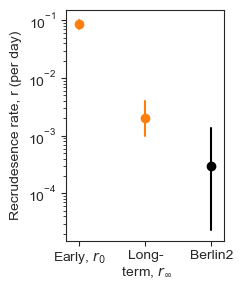

In [11]:
#show as dot plots

plt.figure(figsize=(2.5,3))

plt.scatter(2,threshl[1],color='k')
plt.plot([2,2],[threshl[0],threshl[2]],color='k')

#mean and 95%CI numbers from Conway paper
plt.scatter(0,0.088,color='tab:orange')
plt.plot([0,0],[0.07,0.1],color='tab:orange')
plt.scatter(1,0.002,color='tab:orange')
plt.plot([1,1],[0.001,0.004],color='tab:orange')

plt.xticks([0,1,2],[r'Early, $r_0$','Long-\n term'+r', $r_\infty$','Berlin2'])
plt.ylabel('Recrudesence rate, r (per day)')

plt.semilogy()
plt.xlim([-0.2,2.2])

plt.tight_layout()
plt.savefig('figures/classic-rEst-comparison.pdf',dpi=600)


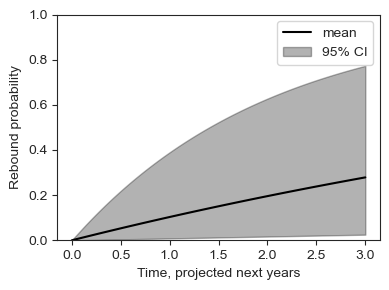

In [12]:
#now rebound probability in next 3 years

tt=np.linspace(0,365*3,100)

hB1=1-np.exp(-tt*threshl[0])
hB2=1-np.exp(-tt*threshl[1]) #int r dt = rt
hB3=1-np.exp(-tt*threshl[2]) #int r dt = rt

plt.figure(figsize=(4,3))
plt.plot(tt/365,hB2,label='mean',color='k')
plt.fill_between(tt/365,hB1,hB3,label='95% CI',color='k',alpha=0.3)

plt.legend()
plt.xlabel('Time, projected next years')
plt.ylabel('Rebound probability')
plt.ylim([0,1])
plt.tight_layout()

/Users/dreeves/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


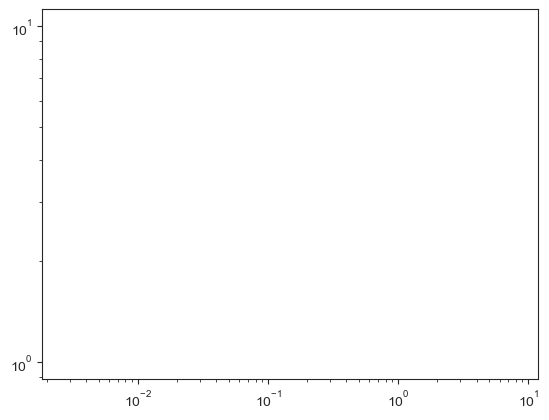

In [15]:
#initial model WITH other mechanisms

#initial model
R0=2 #4/2 for 

xi=1e-5

th=5e-4
#th=np.log(2)/1.5*12/365

L0=1e6

Lt=L0*np.exp(-th*tsim)+1

q=np.min([1,R0])

r = (1-q)*xi*Lt/100

#r=0.05
P   = (1-np.exp(-r*(tsim-tau)))
pVR = np.heaviside(tsim-tau,0)*P

plt.loglog(tsim/365,pVR,label='Simple',color='k')

In [ ]:
R0